## Importando librerias

In [1]:
import pandas as pd
import numpy as np
import sidetable

import matplotlib.pyplot as plt
import seaborn as sns

import math
from scipy.stats import chisquare
from scipy.stats import shapiro
import pylab
import scipy.stats as stats

from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split


from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor 
from sklearn.model_selection import GridSearchCV
from sklearn import tree


from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_validate
from sklearn import metrics

## Leyendo fichero y renombrando columnas

In [2]:
df = pd.read_csv('regression_data.csv', header = None)
df.head(2)

,0,1,2,3,4,5,6,7,8,9,...,11,12,13,14,15,16,17,18,19,20
0,7129300520,10/13/14,3,1.00,1180,5650,1.0,0,0,3,...,1180,0,1955,0,98178,47.5112,-122.257,1340,5650,221900
1,6414100192,12/9/14,3,2.25,2570,7242,2.0,0,0,3,...,2170,400,1951,1991,98125,47.7210,-122.319,1690,7639,538000


In [3]:
columns_rename = {0:'id',
                  1:'date',
                  2:'bedrooms',
                  3:'bathrooms',
                  4:'sqft_living',
                  5:'sqft_lot',
                  6:'floors',
                  7:'waterfront',
                  8:'view',
                  9:'condition',
                  10:'grade',
                  11:'sqft_above',
                  12:'sqft_basement',
                  13:'yr_built',
                  14:'yr_renovated',
                  15:'zipcode',
                  16:'lat',
                  17:'long',
                  18:'sqft_living15',
                  19:'sqft_lot15',
                  20:'price'
                 }


In [4]:
df.rename(columns = columns_rename, inplace = True)


In [5]:
df.head(2)

,id,date,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,...,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15,price
0,7129300520,10/13/14,3,1.00,1180,5650,1.0,0,0,3,...,1180,0,1955,0,98178,47.5112,-122.257,1340,5650,221900
1,6414100192,12/9/14,3,2.25,2570,7242,2.0,0,0,3,...,2170,400,1951,1991,98125,47.7210,-122.319,1690,7639,538000


## Identificando Nulos

In [6]:
df.stb.missing()

,missing,total,percent
id,0,21597,0.0
sqft_above,0,21597,0.0
sqft_lot15,0,21597,0.0
sqft_living15,0,21597,0.0
long,0,21597,0.0
lat,0,21597,0.0
zipcode,0,21597,0.0
yr_renovated,0,21597,0.0
yr_built,0,21597,0.0
sqft_basement,0,21597,0.0


## Generando nueva columna para identificar si esta o no renovado el piso

In [7]:
def renovated(yr_renovated):
    if yr_renovated == 0:
        x = 0
    else:
        x = 1
    
    return x

In [8]:
df["renovated"] = df.apply(lambda x : renovated(x['yr_renovated']), axis=1)

## Gestion de Outliers

In [9]:
lista_columnas = ['bedrooms','sqft_living','sqft_lot','sqft_basement','price']
#df_numericas = df.select_dtypes(include=np.number)
df_numericas = df[lista_columnas]
df_numericas.head(2)

,bedrooms,sqft_living,sqft_lot,sqft_basement,price
0,3,1180,5650,0,221900
1,3,2570,7242,400,538000


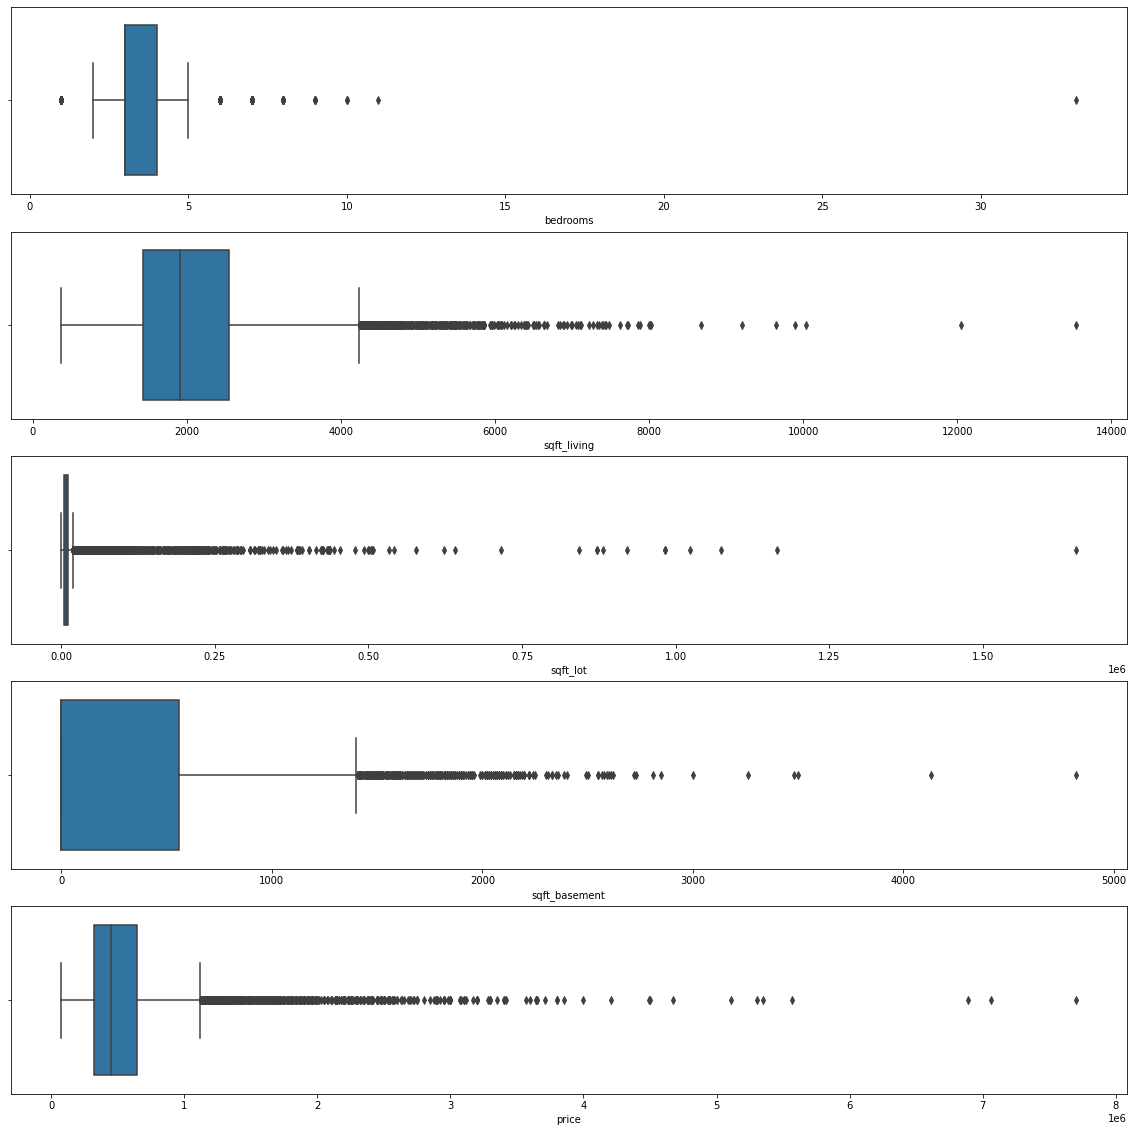

In [10]:
fig, ax = plt.subplots(len(df_numericas.columns), 1, figsize=(20,20))

for i in range(len(df_numericas.columns)):
    sns.boxplot(x=df_numericas.columns[i], data=df_numericas, ax=ax[i])
plt.show()

In [11]:
# bedrooms -> eliminar outlier de 33
# grade -> eliminar grade 3
# sqft_living -> eliminar por encima de 2.5Q
# sqft_lot -> eliminar por encima de 3.5Q
# sqft_basement -> eliminar por encima de 2.5Q
# price -> eliminar por encima de 1.5Q


In [12]:
def detectar_outliers(lista_columnas, dataframe, dict_criteria): 
    
    dicc_indices = {} # creamos un diccionario donde almacenaremos índices de los outliers
    
    # iteramos por la lista de las columnas numéricas de nuestro dataframe
    for col in lista_columnas:
        
        #calculamos los cuartiles Q1 y Q3
        Q1 = np.nanpercentile(df[col], 25)
        Q3 = np.nanpercentile(df[col], 75)
        
        # calculamos el rango intercuartil
        IQR = Q3 - Q1
        
        # calculamos los límites
        outlier_step = dict_criteria[col] * IQR
        
        # filtramos nuestro dataframe para indentificar los outliers
        outliers_data = dataframe[(dataframe[col] < Q1 - outlier_step) | (dataframe[col] > Q3 + outlier_step)]
        
        
        if outliers_data.shape[0] > 0: # chequeamos si nuestro dataframe tiene alguna fila. 
        
            dicc_indices[col] = (list(outliers_data.index)) # si tiene fila es que hay outliers y por lo tanto lo añadimos a nuestro diccionario
        

    
    return dicc_indices 

In [13]:

dict_criteria = {'bedrooms':1.5,
                'sqft_living':2.5,
                 'sqft_lot':3.5,
                 'sqft_basement':2.5,
                 'price':1.5,}

In [14]:
ind = detectar_outliers(lista_columnas, df,dict_criteria)

In [15]:
valores = list(ind.values())
valores = [indice for sublista in valores for indice in sublista]
valores = set(valores)

In [16]:
df_clean = df.copy()

In [17]:
df_final = df_clean.drop(df_clean.index[list(valores)] )

In [18]:

def printing(df,lista_columnas):
    df_numericas = df[lista_columnas]
    df_numericas.head(2)
    
    fig, ax = plt.subplots(len(df_numericas.columns), 1, figsize=(20,20))

    for i in range(len(df_numericas.columns)):
        sns.boxplot(x=df_numericas.columns[i], data=df_numericas, ax=ax[i])
    plt.show()

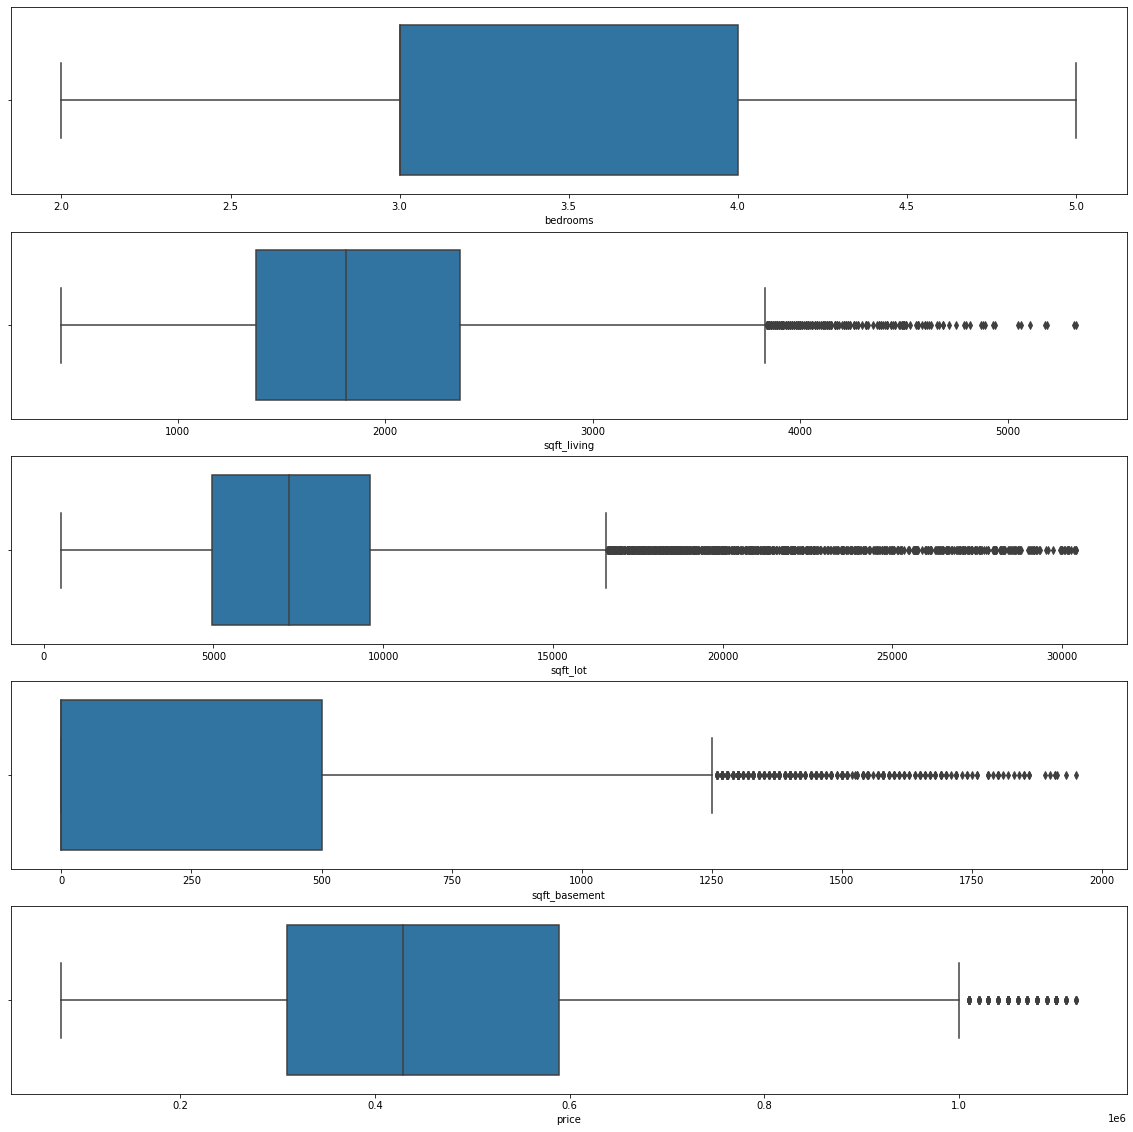

In [19]:
printing(df_final,lista_columnas)

In [20]:

print(df.shape[0],df_final.shape[0])

21597 18477


In [21]:
df_final.drop(columns=['id','date'],inplace=True)

In [22]:
df_final.head(2)

,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15,price,renovated
0,3,1.00,1180,5650,1.0,0,0,3,7,1180,0,1955,0,98178,47.5112,-122.257,1340,5650,221900,0
1,3,2.25,2570,7242,2.0,0,0,3,7,2170,400,1951,1991,98125,47.7210,-122.319,1690,7639,538000,1


## Normalizacion y estandarizcion

In [23]:
norm_column = ['price']

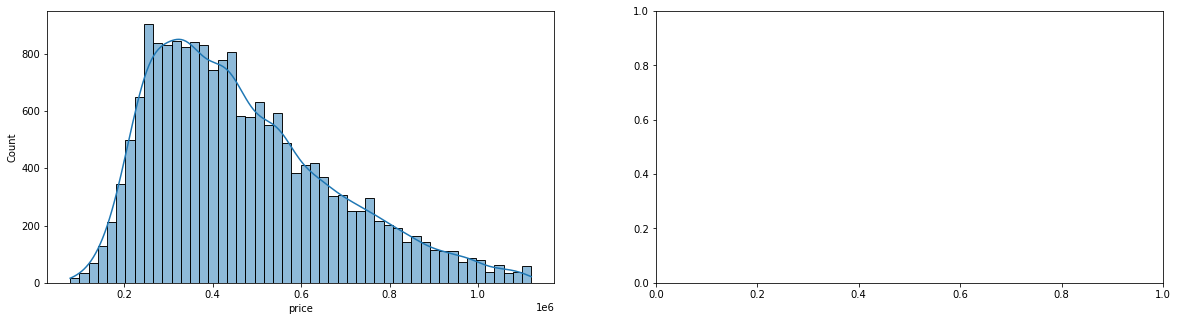

In [24]:
fig, ax = plt.subplots(1,2, figsize = (20,5))

for i in range(len(norm_column)):
    sns.histplot(df_final[norm_column[i]], kde = True, ax = ax[i])
plt.show()

#### Usando sklearn

In [25]:
df = df_final.copy()

# construir el modelo de escalador
minmax = MinMaxScaler()

# ajustamos el modelo utilizando nuestro set de datos
minmax.fit(df[norm_column])


MinMaxScaler()

In [26]:
# transformamos los datos
X_normalizadas = minmax.transform(df[norm_column])

In [27]:
# lo unimos a nuestro dataframe original
df["price_NORM_sklearn"] = X_normalizadas

/Users/eduardoarroyo/opt/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/Users/eduardoarroyo/opt/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


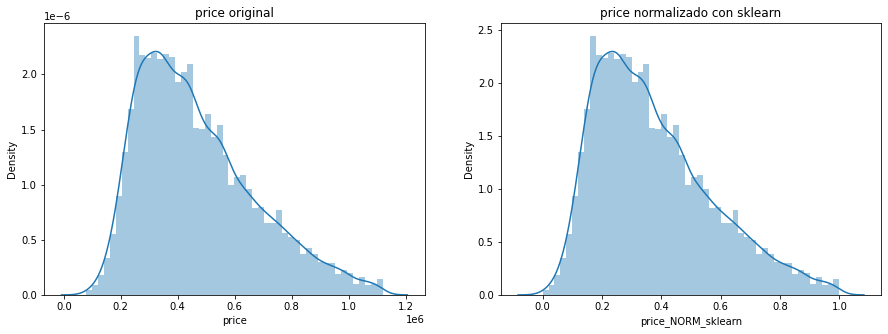

In [28]:


fig, axes = plt.subplots(1, 2, figsize = (15,5))

axes[0].set_title('price original')
axes[1].set_title('price normalizado con sklearn')

sns.distplot(df['price'] ,ax = axes[0])
sns.distplot(df['price_NORM_sklearn'], ax = axes[1]);

No vale para nada hacerlo con sklearn. Empezamos a aplicar logaritmica y cuadratica

#### Logaritmica

In [29]:
df['price_LOG'] = df['price'].apply(lambda x: np.log(x) if x != 0 else 0)

/Users/eduardoarroyo/opt/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/Users/eduardoarroyo/opt/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


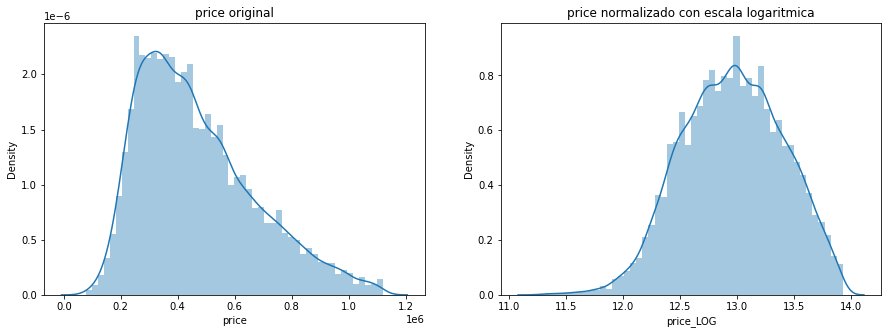

In [30]:
fig, axes = plt.subplots(1, 2, figsize = (15,5))

axes[0].set_title('price original')
axes[1].set_title('price normalizado con escala logaritmica')

sns.distplot(df['price'] ,ax = axes[0])
sns.distplot(df['price_LOG'], ax = axes[1]);

#### Raiz cuadrada

In [31]:
 df['price_SQRT'] = df['price'].apply(lambda x: math.sqrt(x))

/Users/eduardoarroyo/opt/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/Users/eduardoarroyo/opt/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


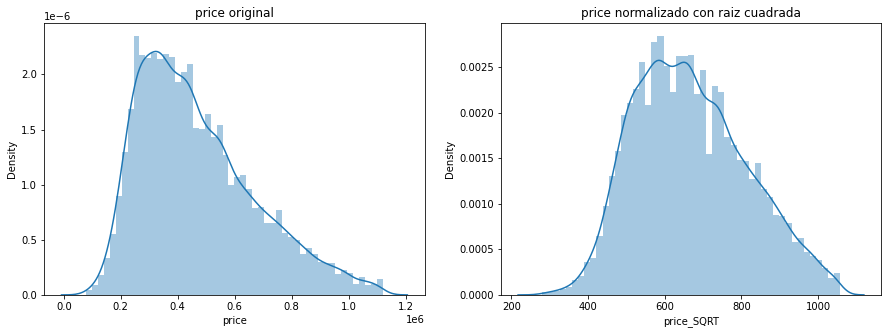

In [32]:
fig, axes = plt.subplots(1, 2, figsize = (15,5))

axes[0].set_title('price original')
axes[1].set_title('price normalizado con raiz cuadrada')

sns.distplot(df['price'] ,ax = axes[0])
sns.distplot(df['price_SQRT'], ax = axes[1]);

#### Examen de Normalidad de cada metodo

In [33]:
def normalidad_chicuadrado(data, method):
    statistic,pvalue = chisquare(data)
    print(method, ' by Chi Cuadrado ','---> statistics=%.3f, p=%.3f\n' % (statistic, pvalue))
    if pvalue > 0.05:
        print('Probably Gaussian\n')
    else:
        print('Probably not Gaussian\n')
        
def normalidad_shapiro(data,method):
    stat, p = shapiro(data)
    print(method, ' by shapiro ','---> stat=%.3f, p=%.3f\n' % (stat,p))
    if p > 0.05:
        print('Probably Gaussian\n')
    else:
        print('Probably not Gaussian\n')
        
def quantil_print(data,method):
    stats.probplot(data,dist="norm", plot=pylab)
    print(method)
    pylab.show()
    

price_NORM_sklearn  by Chi Cuadrado  ---> statistics=1904.643, p=1.000

Probably Gaussian

price_NORM_sklearn  by shapiro  ---> stat=0.948, p=0.000

Probably not Gaussian

price_NORM_sklearn


/Users/eduardoarroyo/opt/anaconda3/lib/python3.9/site-packages/scipy/stats/morestats.py:1760: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


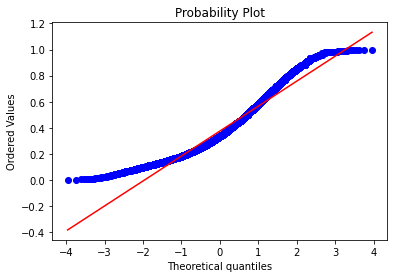

price_LOG  by Chi Cuadrado  ---> statistics=278.940, p=1.000

Probably Gaussian

price_LOG  by shapiro  ---> stat=0.993, p=0.000

Probably not Gaussian



/Users/eduardoarroyo/opt/anaconda3/lib/python3.9/site-packages/scipy/stats/morestats.py:1760: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


price_LOG


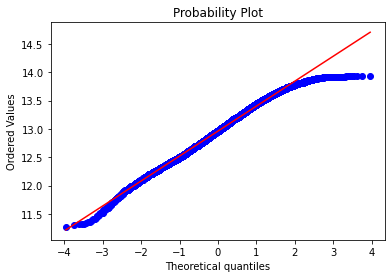

price_SQRT  by Chi Cuadrado  ---> statistics=592236.894, p=0.000

Probably not Gaussian

price_SQRT  by shapiro  ---> stat=0.984, p=0.000

Probably not Gaussian



/Users/eduardoarroyo/opt/anaconda3/lib/python3.9/site-packages/scipy/stats/morestats.py:1760: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


price_SQRT


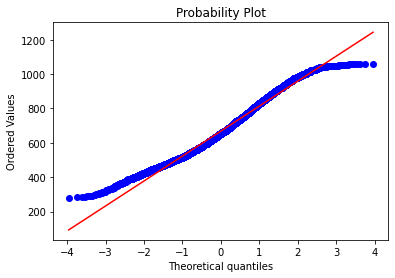

In [34]:
column_tested = ['price_NORM_sklearn','price_LOG','price_SQRT']
for i in column_tested:
    data = df[i]
    method = i
    normalidad_chicuadrado(data,method)
    normalidad_shapiro(data,method)
    quantil_print(data,method)

Debido a el test de chi cuadrado y la representacion por quantilis parece que la normalizacion mejor es la logartimica.

In [35]:
#dropeamos las columnas que no necesitamos
df.drop(columns=['price_NORM_sklearn','price_SQRT'], inplace = True)

#### Estandarizamos la variables predictoras

In [36]:
# iniciamos el método para escalar

scaler = StandardScaler()

In [37]:
# ajustamos nuestros datos
columns_standard = ['bedrooms','bathrooms','sqft_living','sqft_lot','floors'
                    ,'waterfront','view','condition','grade','sqft_above'
                    ,'sqft_basement','yr_built','yr_renovated','zipcode'
                    ,'lat','long','sqft_living15','sqft_lot15']
columns_standard_renamed = ['bedrooms_ES','bathrooms_ES','sqft_living_ES','sqft_lot_ES','floors_ES'
                    ,'waterfront_ES','view_ES','condition_ES','grade_ES','sqft_above_ES'
                    ,'sqft_basement_ES','yr_built_ES','yr_renovated_ES','zipcode_ES'
                    ,'lat_ES','long_ES','sqft_living15_ES','sqft_lot15_ES']

scaler.fit(df[columns_standard])

X_escaladas = scaler.transform(df[columns_standard])

df[columns_standard_renamed] = X_escaladas

Tenemos todo ya estandarizado y normalizado!!

In [38]:
df.head(2)

,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,...,grade_ES,sqft_above_ES,sqft_basement_ES,yr_built_ES,yr_renovated_ES,zipcode_ES,lat_ES,long_ES,sqft_living15_ES,sqft_lot15_ES
0,3,1.00,1180,5650,1.0,0,0,3,7,1180,...,-0.499912,-0.704360,-0.662820,-0.528496,-0.191854,1.803506,-0.343071,-0.244778,-0.917040,-0.371623
1,3,2.25,2570,7242,2.0,0,0,3,7,2170,...,-0.499912,0.744884,0.357104,-0.663909,5.198426,0.822890,1.164605,-0.704024,-0.325887,-0.013902


## A predecir!!

In [39]:
df.drop(columns = columns_standard, inplace = True)

In [40]:
df.head(2)

,price,renovated,price_LOG,bedrooms_ES,bathrooms_ES,sqft_living_ES,sqft_lot_ES,floors_ES,waterfront_ES,view_ES,...,grade_ES,sqft_above_ES,sqft_basement_ES,yr_built_ES,yr_renovated_ES,zipcode_ES,lat_ES,long_ES,sqft_living15_ES,sqft_lot15_ES
0,221900,0,12.309982,-0.381166,-1.492556,-1.029753,-0.470912,-0.878646,-0.048857,-0.260872,...,-0.499912,-0.704360,-0.662820,-0.528496,-0.191854,1.803506,-0.343071,-0.244778,-0.917040,-0.371623
1,538000,1,13.195614,-0.381166,0.321879,0.901622,-0.119414,0.967890,-0.048857,-0.260872,...,-0.499912,0.744884,0.357104,-0.663909,5.198426,0.822890,1.164605,-0.704024,-0.325887,-0.013902


In [41]:
df_limpio = df.copy()

In [42]:
# Reparto de datos en train y test
# ==============================================================================
# lo primero que hacemos es definir cual es nuestra variable Y y nuestras variables X
X = df_limpio.drop(['price','price_LOG'], axis =1)
y = df_limpio['price_LOG']


X_train, X_test, y_train, y_test = train_test_split(X, y, train_size   = 0.8, random_state = 42)

In [43]:
def metricas(y_test, y_train, y_test_pred, y_train_pred, tipo_modelo):
    
    
    resultados = {'MAE': [metrics.mean_absolute_error(y_test, y_test_pred), metrics.mean_absolute_error(y_train, y_train_pred)],
                'MSE': [metrics.mean_squared_error(y_test, y_test_pred), metrics.mean_squared_error(y_train, y_train_pred)],
                'RMSE': [np.sqrt(metrics.mean_squared_error(y_test, y_test_pred)), np.sqrt(metrics.mean_squared_error(y_train, y_train_pred))],
                'R2':  [metrics.r2_score(y_test, y_test_pred), metrics.r2_score(y_train, y_train_pred)],
                 "set": ["test", "train"]}
    df = pd.DataFrame(resultados)
    df["modelo"] = tipo_modelo
    return df

#### Usamos la regresion lineal

entrenamos el modelo...

In [44]:
# iniciamos el método de Linear Regression
lr = LinearRegression()

# es el momento de ajustar el modelo. Para eso usaremos el método .fit() donde le tendremos que pasar las variables predictoras y la respuesta

lr.fit(X_train, y_train)

LinearRegression()

y ahora predecimos!

In [45]:
# hacemos las predicciones sobre los dos set de datos el X_test y el X_train
y_pred_test = lr.predict(X_test)
y_pred_train = lr.predict(X_train)

In [46]:
lr_results = metricas(y_test, y_train, y_pred_test, y_pred_train, "Regresion lineal")
lr_results

,MAE,MSE,RMSE,R2,set,modelo
0,0.181303,0.054454,0.233355,0.722805,test,Regresion lineal
1,0.180144,0.054077,0.232545,0.723365,train,Regresion lineal


#### Usamos la Decission Tree

entrenamos el primer modelo sin limites!!

In [47]:
# create a regressor object
regressor = DecisionTreeRegressor(random_state = 0) 
  
# fit the regressor with X and Y data
regressor.fit(X_train, y_train)

DecisionTreeRegressor(random_state=0)

In [48]:
# max features

max_features = np.sqrt(len(X_train.columns))
max_features

4.358898943540674

In [49]:
# max depth

print(regressor.tree_.max_depth)

34


In [50]:
# hacemos las predicciones sobre los dos set de datos el X_test y el X_train
y_pred_test_dt = regressor.predict(X_test)
y_pred_train_dt = regressor.predict(X_train)

In [51]:
# sacamos las métricas para ver si hay overfitting

dt_results1 = metricas(y_test, y_train, y_pred_test_dt, y_pred_train_dt, "Decission Tree I")
dt_results1

,MAE,MSE,RMSE,R2,set,modelo
0,0.165695,0.053371,0.231021,0.728322,test,Decission Tree I
1,0.002254,0.000603,0.024556,0.996915,train,Decission Tree I


el overfiting es evidente... Asi que nos toca ajustar con gridsearch

In [52]:
# Generación del GridSearch
# ==============================================================================

# definimos un diccionario con los hiperparámetros que queremos testear. 
param = {"max_depth": [4, 5, 6, 7],
        "min_samples_split": [10, 50, 100],
        "max_features": [1,2,3,4]}

gs = GridSearchCV(
            estimator=DecisionTreeRegressor(),
            param_grid= param,
            cv=10,
            verbose=6,
            return_train_score = True,
            scoring="neg_mean_squared_error")

In [53]:
# ajustamos el modelo de nuevo

%time
gs.fit(X_train, y_train)

CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 9.06 µs
Fitting 10 folds for each of 48 candidates, totalling 480 fits
[CV 1/10] END max_depth=4, max_features=1, min_samples_split=10;, score=(train=-0.155, test=-0.156) total time=   0.0s
[CV 2/10] END max_depth=4, max_features=1, min_samples_split=10;, score=(train=-0.118, test=-0.121) total time=   0.0s
[CV 3/10] END max_depth=4, max_features=1, min_samples_split=10;, score=(train=-0.155, test=-0.159) total time=   0.0s
[CV 4/10] END max_depth=4, max_features=1, min_samples_split=10;, score=(train=-0.129, test=-0.133) total time=   0.0s
[CV 5/10] END max_depth=4, max_features=1, min_samples_split=10;, score=(train=-0.143, test=-0.140) total time=   0.0s
[CV 6/10] END max_depth=4, max_features=1, min_samples_split=10;, score=(train=-0.118, test=-0.122) total time=   0.0s
[CV 7/10] END max_depth=4, max_features=1, min_samples_split=10;, score=(train=-0.128, test=-0.124) total time=   0.0s
[CV 8/10] END max_depth=4, max_features=

[CV 9/10] END max_depth=4, max_features=3, min_samples_split=10;, score=(train=-0.074, test=-0.082) total time=   0.0s
[CV 10/10] END max_depth=4, max_features=3, min_samples_split=10;, score=(train=-0.122, test=-0.124) total time=   0.0s
[CV 1/10] END max_depth=4, max_features=3, min_samples_split=50;, score=(train=-0.083, test=-0.086) total time=   0.0s
[CV 2/10] END max_depth=4, max_features=3, min_samples_split=50;, score=(train=-0.093, test=-0.091) total time=   0.0s
[CV 3/10] END max_depth=4, max_features=3, min_samples_split=50;, score=(train=-0.064, test=-0.068) total time=   0.0s
[CV 4/10] END max_depth=4, max_features=3, min_samples_split=50;, score=(train=-0.075, test=-0.081) total time=   0.0s
[CV 5/10] END max_depth=4, max_features=3, min_samples_split=50;, score=(train=-0.087, test=-0.083) total time=   0.0s
[CV 6/10] END max_depth=4, max_features=3, min_samples_split=50;, score=(train=-0.099, test=-0.104) total time=   0.0s
[CV 7/10] END max_depth=4, max_features=3, min_

[CV 2/10] END max_depth=5, max_features=1, min_samples_split=100;, score=(train=-0.135, test=-0.138) total time=   0.0s
[CV 3/10] END max_depth=5, max_features=1, min_samples_split=100;, score=(train=-0.152, test=-0.165) total time=   0.0s
[CV 4/10] END max_depth=5, max_features=1, min_samples_split=100;, score=(train=-0.175, test=-0.179) total time=   0.0s
[CV 5/10] END max_depth=5, max_features=1, min_samples_split=100;, score=(train=-0.071, test=-0.070) total time=   0.0s
[CV 6/10] END max_depth=5, max_features=1, min_samples_split=100;, score=(train=-0.138, test=-0.137) total time=   0.0s
[CV 7/10] END max_depth=5, max_features=1, min_samples_split=100;, score=(train=-0.129, test=-0.130) total time=   0.0s
[CV 8/10] END max_depth=5, max_features=1, min_samples_split=100;, score=(train=-0.128, test=-0.131) total time=   0.0s
[CV 9/10] END max_depth=5, max_features=1, min_samples_split=100;, score=(train=-0.085, test=-0.097) total time=   0.0s
[CV 10/10] END max_depth=5, max_features

[CV 7/10] END max_depth=5, max_features=4, min_samples_split=10;, score=(train=-0.084, test=-0.085) total time=   0.0s
[CV 8/10] END max_depth=5, max_features=4, min_samples_split=10;, score=(train=-0.058, test=-0.062) total time=   0.0s
[CV 9/10] END max_depth=5, max_features=4, min_samples_split=10;, score=(train=-0.083, test=-0.090) total time=   0.0s
[CV 10/10] END max_depth=5, max_features=4, min_samples_split=10;, score=(train=-0.063, test=-0.062) total time=   0.0s
[CV 1/10] END max_depth=5, max_features=4, min_samples_split=50;, score=(train=-0.071, test=-0.077) total time=   0.0s
[CV 2/10] END max_depth=5, max_features=4, min_samples_split=50;, score=(train=-0.081, test=-0.083) total time=   0.0s
[CV 3/10] END max_depth=5, max_features=4, min_samples_split=50;, score=(train=-0.085, test=-0.090) total time=   0.0s
[CV 4/10] END max_depth=5, max_features=4, min_samples_split=50;, score=(train=-0.077, test=-0.080) total time=   0.0s
[CV 5/10] END max_depth=5, max_features=4, min_

[CV 2/10] END max_depth=6, max_features=2, min_samples_split=100;, score=(train=-0.071, test=-0.074) total time=   0.0s
[CV 3/10] END max_depth=6, max_features=2, min_samples_split=100;, score=(train=-0.098, test=-0.101) total time=   0.0s
[CV 4/10] END max_depth=6, max_features=2, min_samples_split=100;, score=(train=-0.097, test=-0.108) total time=   0.0s
[CV 5/10] END max_depth=6, max_features=2, min_samples_split=100;, score=(train=-0.108, test=-0.105) total time=   0.0s
[CV 6/10] END max_depth=6, max_features=2, min_samples_split=100;, score=(train=-0.113, test=-0.116) total time=   0.0s
[CV 7/10] END max_depth=6, max_features=2, min_samples_split=100;, score=(train=-0.116, test=-0.117) total time=   0.0s
[CV 8/10] END max_depth=6, max_features=2, min_samples_split=100;, score=(train=-0.099, test=-0.102) total time=   0.0s
[CV 9/10] END max_depth=6, max_features=2, min_samples_split=100;, score=(train=-0.078, test=-0.087) total time=   0.0s
[CV 10/10] END max_depth=6, max_features

[CV 4/10] END max_depth=7, max_features=1, min_samples_split=10;, score=(train=-0.084, test=-0.089) total time=   0.0s
[CV 5/10] END max_depth=7, max_features=1, min_samples_split=10;, score=(train=-0.102, test=-0.101) total time=   0.0s
[CV 6/10] END max_depth=7, max_features=1, min_samples_split=10;, score=(train=-0.124, test=-0.131) total time=   0.0s
[CV 7/10] END max_depth=7, max_features=1, min_samples_split=10;, score=(train=-0.062, test=-0.066) total time=   0.0s
[CV 8/10] END max_depth=7, max_features=1, min_samples_split=10;, score=(train=-0.069, test=-0.076) total time=   0.0s
[CV 9/10] END max_depth=7, max_features=1, min_samples_split=10;, score=(train=-0.101, test=-0.107) total time=   0.0s
[CV 10/10] END max_depth=7, max_features=1, min_samples_split=10;, score=(train=-0.112, test=-0.110) total time=   0.0s
[CV 1/10] END max_depth=7, max_features=1, min_samples_split=50;, score=(train=-0.141, test=-0.140) total time=   0.0s
[CV 2/10] END max_depth=7, max_features=1, min_

[CV 5/10] END max_depth=7, max_features=3, min_samples_split=50;, score=(train=-0.065, test=-0.065) total time=   0.0s
[CV 6/10] END max_depth=7, max_features=3, min_samples_split=50;, score=(train=-0.076, test=-0.080) total time=   0.0s
[CV 7/10] END max_depth=7, max_features=3, min_samples_split=50;, score=(train=-0.050, test=-0.053) total time=   0.0s
[CV 8/10] END max_depth=7, max_features=3, min_samples_split=50;, score=(train=-0.067, test=-0.072) total time=   0.0s
[CV 9/10] END max_depth=7, max_features=3, min_samples_split=50;, score=(train=-0.069, test=-0.075) total time=   0.0s
[CV 10/10] END max_depth=7, max_features=3, min_samples_split=50;, score=(train=-0.082, test=-0.090) total time=   0.0s
[CV 1/10] END max_depth=7, max_features=3, min_samples_split=100;, score=(train=-0.076, test=-0.081) total time=   0.0s
[CV 2/10] END max_depth=7, max_features=3, min_samples_split=100;, score=(train=-0.072, test=-0.078) total time=   0.0s
[CV 3/10] END max_depth=7, max_features=3, mi

GridSearchCV(cv=10, estimator=DecisionTreeRegressor(),
             param_grid={'max_depth': [4, 5, 6, 7],
                         'max_features': [1, 2, 3, 4],
                         'min_samples_split': [10, 50, 100]},
             return_train_score=True, scoring='neg_mean_squared_error',
             verbose=6)

In [54]:
# sacamos cual es el mejor de todos los que hemos testeado usando el método best_estimator_

best_tree = gs.best_estimator_
best_tree


DecisionTreeRegressor(max_depth=7, max_features=4, min_samples_split=100)

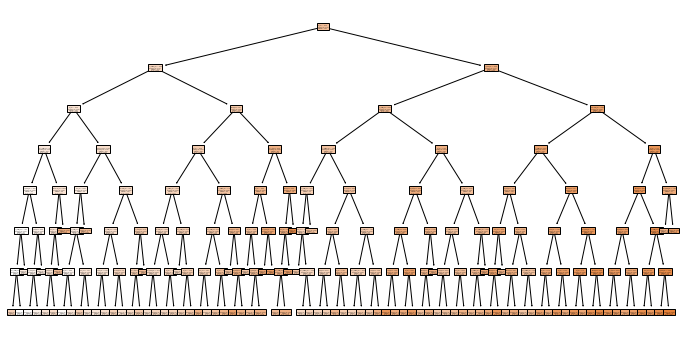

In [55]:
# vamos a visualizar el árbol a ver como se ve: 

fig = plt.figure(figsize=(12, 6))
tree.plot_tree(best_tree, feature_names=X_train.columns, filled=True);

ahora a predecir:

In [56]:
y_pred_test_dt2 = best_tree.predict(X_test)
y_pred_train_dt2 = best_tree.predict(X_train)

In [57]:
dt_results2 = metricas(y_test, y_train, y_pred_test_dt2, y_pred_train_dt2, "Decision tree II")
dt_results2

,MAE,MSE,RMSE,R2,set,modelo
0,0.168589,0.051208,0.226293,0.739329,test,Decision tree II
1,0.158697,0.045275,0.212779,0.768392,train,Decision tree II


podemos ver que no tiene tanto overiting...

ahora vamos a comparar los metodos utilizados hasta el momento:

In [58]:
df_all = pd.concat([lr_results, dt_results1, dt_results2], axis = 0)
df_all

,MAE,MSE,RMSE,R2,set,modelo
0,0.181303,0.054454,0.233355,0.722805,test,Regresion lineal
1,0.180144,0.054077,0.232545,0.723365,train,Regresion lineal
0,0.165695,0.053371,0.231021,0.728322,test,Decission Tree I
1,0.002254,0.000603,0.024556,0.996915,train,Decission Tree I
0,0.168589,0.051208,0.226293,0.739329,test,Decision tree II
1,0.158697,0.045275,0.212779,0.768392,train,Decision tree II


/Users/eduardoarroyo/opt/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/Users/eduardoarroyo/opt/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


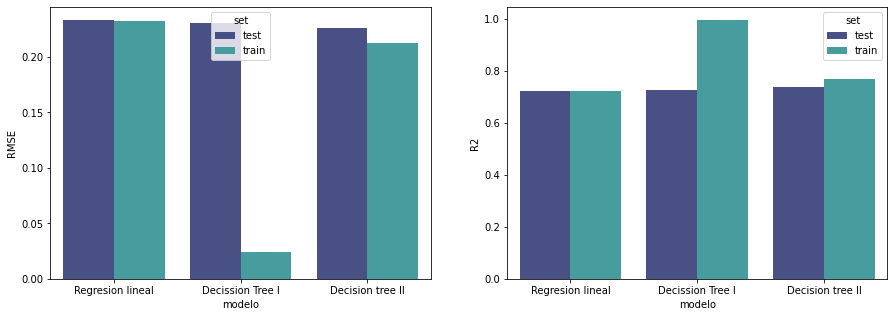

In [59]:
fig, axes = plt.subplots(1,2, figsize =(15,5))

sns.barplot(df_all.modelo, df_all.RMSE, hue = df_all.set, ax = axes[0], palette="mako")
sns.barplot(df_all.modelo, df_all.R2, hue = df_all.set, ax = axes[1], palette = "mako");

Vamos a ver la importancia de cada variable por si podemos simplificar los modelos:

In [60]:
importancia_predictores = pd.DataFrame(
                            {'predictor': X_train.columns,
                             'importancia': regressor.feature_importances_}
                            )

In [61]:
# ordenamos los resultados

importancia_predictores.sort_values( ascending=False, by= "importancia", inplace=True)

In [62]:

print("Importancia de los predictores en el modelo")
print("-------------------------------------------")
importancia_predictores

Importancia de los predictores en el modelo
-------------------------------------------


,predictor,importancia
15,lat_ES,0.481250
3,sqft_living_ES,0.297056
16,long_ES,0.051340
9,grade_ES,0.043682
17,sqft_living15_ES,0.025851
12,yr_built_ES,0.017135
4,sqft_lot_ES,0.015807
10,sqft_above_ES,0.014068
18,sqft_lot15_ES,0.013479
14,zipcode_ES,0.009394


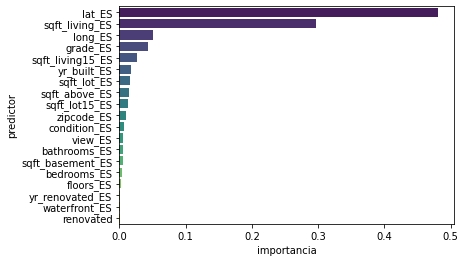

In [63]:
#y por último los ploteamos

sns.barplot(x = "importancia", y = "predictor", data = importancia_predictores, palette="viridis");

#### Usamos la Random Forest

Ajustamos el modelo usando GridSearch

In [64]:
param = {"max_depth": [4, 5, 6, 7],
        "min_samples_split": [10, 50, 100],
        "max_features": [1,2,3,4]}

bosque = GridSearchCV(
            estimator=RandomForestRegressor(),
            param_grid= param,
            cv=10,
            verbose=6,
            return_train_score = True,
            scoring="neg_mean_squared_error")

In [65]:
%time
bosque.fit(X_train, y_train)

CPU times: user 3 µs, sys: 1e+03 ns, total: 4 µs
Wall time: 5.72 µs
Fitting 10 folds for each of 48 candidates, totalling 480 fits
[CV 1/10] END max_depth=4, max_features=1, min_samples_split=10;, score=(train=-0.099, test=-0.097) total time=   0.4s
[CV 2/10] END max_depth=4, max_features=1, min_samples_split=10;, score=(train=-0.096, test=-0.099) total time=   0.3s
[CV 3/10] END max_depth=4, max_features=1, min_samples_split=10;, score=(train=-0.101, test=-0.106) total time=   0.3s
[CV 4/10] END max_depth=4, max_features=1, min_samples_split=10;, score=(train=-0.098, test=-0.104) total time=   0.4s
[CV 5/10] END max_depth=4, max_features=1, min_samples_split=10;, score=(train=-0.104, test=-0.098) total time=   0.3s
[CV 6/10] END max_depth=4, max_features=1, min_samples_split=10;, score=(train=-0.105, test=-0.106) total time=   0.3s
[CV 7/10] END max_depth=4, max_features=1, min_samples_split=10;, score=(train=-0.094, test=-0.092) total time=   0.4s
[CV 8/10] END max_depth=4, max_featu

[CV 9/10] END max_depth=4, max_features=3, min_samples_split=10;, score=(train=-0.064, test=-0.069) total time=   0.7s
[CV 10/10] END max_depth=4, max_features=3, min_samples_split=10;, score=(train=-0.063, test=-0.061) total time=   0.6s
[CV 1/10] END max_depth=4, max_features=3, min_samples_split=50;, score=(train=-0.065, test=-0.064) total time=   0.6s
[CV 2/10] END max_depth=4, max_features=3, min_samples_split=50;, score=(train=-0.063, test=-0.063) total time=   0.6s
[CV 3/10] END max_depth=4, max_features=3, min_samples_split=50;, score=(train=-0.063, test=-0.066) total time=   0.6s
[CV 4/10] END max_depth=4, max_features=3, min_samples_split=50;, score=(train=-0.063, test=-0.067) total time=   0.6s
[CV 5/10] END max_depth=4, max_features=3, min_samples_split=50;, score=(train=-0.061, test=-0.058) total time=   0.6s
[CV 6/10] END max_depth=4, max_features=3, min_samples_split=50;, score=(train=-0.067, test=-0.068) total time=   0.6s
[CV 7/10] END max_depth=4, max_features=3, min_

[CV 8/10] END max_depth=5, max_features=1, min_samples_split=50;, score=(train=-0.086, test=-0.088) total time=   0.4s
[CV 9/10] END max_depth=5, max_features=1, min_samples_split=50;, score=(train=-0.082, test=-0.087) total time=   0.4s
[CV 10/10] END max_depth=5, max_features=1, min_samples_split=50;, score=(train=-0.090, test=-0.089) total time=   0.4s
[CV 1/10] END max_depth=5, max_features=1, min_samples_split=100;, score=(train=-0.085, test=-0.085) total time=   0.4s
[CV 2/10] END max_depth=5, max_features=1, min_samples_split=100;, score=(train=-0.083, test=-0.086) total time=   0.4s
[CV 3/10] END max_depth=5, max_features=1, min_samples_split=100;, score=(train=-0.092, test=-0.097) total time=   0.4s
[CV 4/10] END max_depth=5, max_features=1, min_samples_split=100;, score=(train=-0.087, test=-0.093) total time=   0.4s
[CV 5/10] END max_depth=5, max_features=1, min_samples_split=100;, score=(train=-0.080, test=-0.075) total time=   0.4s
[CV 6/10] END max_depth=5, max_features=1,

[CV 7/10] END max_depth=5, max_features=3, min_samples_split=100;, score=(train=-0.052, test=-0.051) total time=   0.8s
[CV 8/10] END max_depth=5, max_features=3, min_samples_split=100;, score=(train=-0.054, test=-0.058) total time=   0.7s
[CV 9/10] END max_depth=5, max_features=3, min_samples_split=100;, score=(train=-0.051, test=-0.056) total time=   0.8s
[CV 10/10] END max_depth=5, max_features=3, min_samples_split=100;, score=(train=-0.053, test=-0.052) total time=   0.7s
[CV 1/10] END max_depth=5, max_features=4, min_samples_split=10;, score=(train=-0.048, test=-0.050) total time=   0.9s
[CV 2/10] END max_depth=5, max_features=4, min_samples_split=10;, score=(train=-0.047, test=-0.048) total time=   0.9s
[CV 3/10] END max_depth=5, max_features=4, min_samples_split=10;, score=(train=-0.047, test=-0.050) total time=   0.9s
[CV 4/10] END max_depth=5, max_features=4, min_samples_split=10;, score=(train=-0.048, test=-0.052) total time=   0.9s
[CV 5/10] END max_depth=5, max_features=4, 

[CV 6/10] END max_depth=6, max_features=2, min_samples_split=10;, score=(train=-0.054, test=-0.056) total time=   0.6s
[CV 7/10] END max_depth=6, max_features=2, min_samples_split=10;, score=(train=-0.054, test=-0.054) total time=   0.6s
[CV 8/10] END max_depth=6, max_features=2, min_samples_split=10;, score=(train=-0.055, test=-0.059) total time=   0.6s
[CV 9/10] END max_depth=6, max_features=2, min_samples_split=10;, score=(train=-0.054, test=-0.059) total time=   0.6s
[CV 10/10] END max_depth=6, max_features=2, min_samples_split=10;, score=(train=-0.055, test=-0.055) total time=   0.6s
[CV 1/10] END max_depth=6, max_features=2, min_samples_split=50;, score=(train=-0.054, test=-0.055) total time=   0.6s
[CV 2/10] END max_depth=6, max_features=2, min_samples_split=50;, score=(train=-0.055, test=-0.057) total time=   0.6s
[CV 3/10] END max_depth=6, max_features=2, min_samples_split=50;, score=(train=-0.055, test=-0.059) total time=   0.6s
[CV 4/10] END max_depth=6, max_features=2, min_

[CV 5/10] END max_depth=6, max_features=4, min_samples_split=50;, score=(train=-0.041, test=-0.040) total time=   1.3s
[CV 6/10] END max_depth=6, max_features=4, min_samples_split=50;, score=(train=-0.041, test=-0.043) total time=   1.0s
[CV 7/10] END max_depth=6, max_features=4, min_samples_split=50;, score=(train=-0.042, test=-0.042) total time=   1.0s
[CV 8/10] END max_depth=6, max_features=4, min_samples_split=50;, score=(train=-0.041, test=-0.046) total time=   1.1s
[CV 9/10] END max_depth=6, max_features=4, min_samples_split=50;, score=(train=-0.042, test=-0.046) total time=   1.1s
[CV 10/10] END max_depth=6, max_features=4, min_samples_split=50;, score=(train=-0.041, test=-0.042) total time=   1.1s
[CV 1/10] END max_depth=6, max_features=4, min_samples_split=100;, score=(train=-0.041, test=-0.044) total time=   1.0s
[CV 2/10] END max_depth=6, max_features=4, min_samples_split=100;, score=(train=-0.043, test=-0.045) total time=   1.0s
[CV 3/10] END max_depth=6, max_features=4, mi

[CV 4/10] END max_depth=7, max_features=2, min_samples_split=100;, score=(train=-0.051, test=-0.056) total time=   0.7s
[CV 5/10] END max_depth=7, max_features=2, min_samples_split=100;, score=(train=-0.049, test=-0.047) total time=   0.7s
[CV 6/10] END max_depth=7, max_features=2, min_samples_split=100;, score=(train=-0.050, test=-0.052) total time=   0.7s
[CV 7/10] END max_depth=7, max_features=2, min_samples_split=100;, score=(train=-0.050, test=-0.050) total time=   0.7s
[CV 8/10] END max_depth=7, max_features=2, min_samples_split=100;, score=(train=-0.048, test=-0.053) total time=   0.7s
[CV 9/10] END max_depth=7, max_features=2, min_samples_split=100;, score=(train=-0.048, test=-0.052) total time=   0.7s
[CV 10/10] END max_depth=7, max_features=2, min_samples_split=100;, score=(train=-0.050, test=-0.051) total time=   0.7s
[CV 1/10] END max_depth=7, max_features=3, min_samples_split=10;, score=(train=-0.039, test=-0.043) total time=   0.9s
[CV 2/10] END max_depth=7, max_features=

GridSearchCV(cv=10, estimator=RandomForestRegressor(),
             param_grid={'max_depth': [4, 5, 6, 7],
                         'max_features': [1, 2, 3, 4],
                         'min_samples_split': [10, 50, 100]},
             return_train_score=True, scoring='neg_mean_squared_error',
             verbose=6)

In [66]:
bos = bosque.best_estimator_
bos

RandomForestRegressor(max_depth=7, max_features=4, min_samples_split=10)

ahora predecimos....

In [67]:
y_pred_test_rf = bos.predict(X_test)
y_pred_train_rf = bos.predict(X_train)

In [68]:
rf_results = metricas(y_test, y_train, y_pred_test_rf, y_pred_train_rf, "Random Forest")
rf_results

,MAE,MSE,RMSE,R2,set,modelo
0,0.146482,0.039159,0.197886,0.800667,test,Random Forest
1,0.141306,0.035814,0.189247,0.816789,train,Random Forest


ahora comparamos con el resto de modelos que hemos probado:

In [69]:
df_all = pd.concat([df_all, rf_results ], axis = 0)
df_all

,MAE,MSE,RMSE,R2,set,modelo
0,0.181303,0.054454,0.233355,0.722805,test,Regresion lineal
1,0.180144,0.054077,0.232545,0.723365,train,Regresion lineal
0,0.165695,0.053371,0.231021,0.728322,test,Decission Tree I
1,0.002254,0.000603,0.024556,0.996915,train,Decission Tree I
0,0.168589,0.051208,0.226293,0.739329,test,Decision tree II
1,0.158697,0.045275,0.212779,0.768392,train,Decision tree II
0,0.146482,0.039159,0.197886,0.800667,test,Random Forest
1,0.141306,0.035814,0.189247,0.816789,train,Random Forest


/Users/eduardoarroyo/opt/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/Users/eduardoarroyo/opt/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


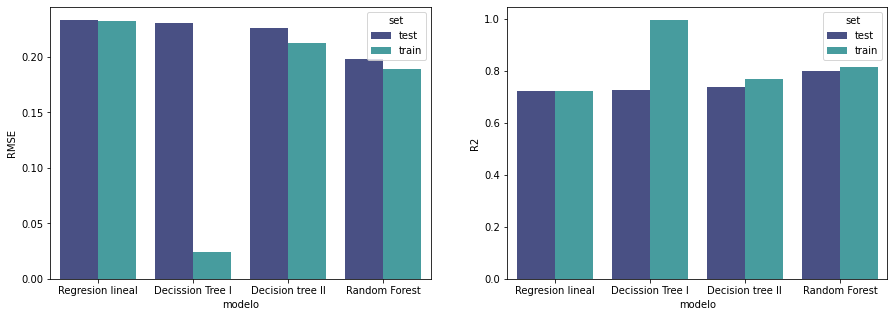

In [70]:
fig, axes = plt.subplots(1,2, figsize =(15,5))

sns.barplot(df_all.modelo, df_all.RMSE, hue = df_all.set, ax = axes[0], palette="mako")
sns.barplot(df_all.modelo, df_all.R2, hue = df_all.set, ax = axes[1], palette = "mako");

vemos las importancias de cada variable:

In [71]:
importancia_predictores_rf = pd.DataFrame(
                            {'predictor': X_train.columns,
                             'importancia': bos.feature_importances_})
importancia_predictores_rf.sort_values( ascending=False, by= "importancia", inplace=True)

# EL MEJOR MODELO ES EL RANDOM FOREST!!! YUPI JEJE